# FAIDM Group Project: CRISP-DM Analysis
## Student Performance Prediction & Clustering
### Open University Learning Analytics Dataset (OULAD)

---

**Module:** WM9QG-15 Fundamentals of AI and Data Mining

**Dataset:** OULAD Mega Table
- **Each row = one student's enrollment in one module presentation**
- Contains: demographics, VLE clicks, assessment scores, registration info

**Tasks:**
1. **Predictive Model** (Classification): Predict Pass/Distinction vs Fail/Withdrawn
2. **Clustering Model** (K-Means): Segment students by engagement patterns

---

# 0️⃣ Introduction

This notebook follows **CRISP-DM**:
1. Business Understanding
2. Data Understanding  
3. Data Preparation
4. Modelling
5. Evaluation
6. Deployment

**Prerequisite:** Run `Create_Mega_Table.ipynb` first to generate `oulad_mega_table.csv`

# 1️⃣ Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, classification_report, confusion_matrix,
                             roc_curve, silhouette_score, davies_bouldin_score)

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

print("Libraries loaded!")

Libraries loaded!


---

# 2️⃣ Phase 1: Business Understanding

## Business Objectives

The Open University wants to:
1. **Identify at-risk students early** for intervention
2. **Understand engagement patterns** to improve retention

## Data Mining Goals

| Task | Type | Goal | Success Metric |
|------|------|------|----------------|
| Task 1 | Classification | Predict student success/failure | AUC-ROC > 0.75 |
| Task 2 | Clustering | Segment students into groups | Silhouette > 0.2 |

---

# 3️⃣ Phase 2: Data Understanding

## 3.1 Load the Mega Table

In [2]:
# Load data - UPDATE PATH if needed
df = pd.read_csv('oulad_mega_table.csv')

print("Data loaded!")
print("-" * 60)
print(f"Shape: {df.shape[0]:,} rows x {df.shape[1]} columns")
print(f"\n📌 Each row = one student enrolled in one module")
print("-" * 60)

Data loaded!
------------------------------------------------------------
Shape: 32,593 rows x 68 columns

📌 Each row = one student enrolled in one module
------------------------------------------------------------


In [3]:
# Preview the data
print("First 5 rows:")
df.head()

First 5 rows:


,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,student_module_key,module_presentation_length,date_registration,date_unregistration,assess_score_mean,assess_score_std,assess_score_min,assess_score_max,assess_count,assess_submit_day_mean,assess_submit_day_min,assess_submit_day_max,assess_banked_count,assess_days_early_mean,assess_days_early_worst,assess_total_weight,tma_score_mean,tma_count,cma_score_mean,cma_count,exam_score_mean,exam_count,vle_total_clicks,vle_avg_daily_clicks,vle_click_std,vle_max_daily_clicks,vle_first_access_day,vle_last_access_day,vle_active_days,vle_unique_resources,vle_engagement_span,vle_clicks_per_active_day,vle_early_clicks,vle_early_active_days,vle_early_resources,vle_pre_course_clicks,vle_clicks_dataplus,vle_clicks_dualpane,vle_clicks_externalquiz,vle_clicks_folder,vle_clicks_forumng,vle_clicks_glossary,vle_clicks_homepage,vle_clicks_htmlactivity,vle_clicks_oucollaborate,vle_clicks_oucontent,vle_clicks_ouelluminate,vle_clicks_ouwiki,vle_clicks_page,vle_clicks_questionnaire,vle_clicks_quiz,vle_clicks_repeatactivity,vle_clicks_resource,vle_clicks_sharedsubpage,vle_clicks_subpage,vle_clicks_url
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,11391_AAA_2013J,268,-159.0,NaN,82.0,3.082207,78.0,85.0,5.0,112.4,18.0,212.0,0.0,1.8,1.0,100.0,82.0,5.0,NaN,NaN,NaN,NaN,934.0,4.765306,7.591224,76.0,-5.0,253.0,40.0,55.0,258.0,23.350000,301.0,6.0,21.0,98.0,0.0,0.0,0.0,0.0,193.0,0.0,138.0,0.0,0.0,553.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,32.0,5.0
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,28400_AAA_2013J,268,-53.0,NaN,66.4,4.335897,60.0,70.0,5.0,114.2,22.0,212.0,0.0,0.0,-4.0,100.0,66.4,5.0,NaN,NaN,NaN,NaN,1435.0,3.337209,3.634240,23.0,-10.0,239.0,80.0,84.0,249.0,17.937500,456.0,14.0,29.0,215.0,10.0,0.0,0.0,0.0,417.0,0.0,324.0,0.0,0.0,537.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,87.0,48.0
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,30268_AAA_2013J,268,-92.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,281.0,3.697368,4.056336,23.0,-10.0,12.0,12.0,22.0,22.0,23.416667,281.0,12.0,22.0,102.0,0.0,0.0,0.0,0.0,126.0,0.0,59.0,0.0,0.0,66.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,22.0,4.0
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,31604_AAA_2013J,268,-52.0,NaN,76.0,6.892024,71.0,88.0,5.0,112.2,17.0,213.0,0.0,2.0,1.0,100.0,76.0,5.0,NaN,NaN,NaN,NaN,2158.0,3.254902,3.194577,22.0,-10.0,264.0,123.0,82.0,274.0,17.544715,349.0,13.0,24.0,169.0,2.0,0.0,0.0,0.0,634.0,1.0,432.0,0.0,0.0,836.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,0.0,144.0,90.0
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,32885_AAA_2013J,268,-176.0,NaN,54.4,20.513410,30.0,75.0,5.0,125.6,26.0,222.0,0.0,-11.4,-21.0,100.0,54.4,5.0,NaN,NaN,NaN,NaN,1034.0,2.937500,3.261895,22.0,-10.0,247.0,70.0,66.0,257.0,14.771429,472.0,17.0,30.0,295.0,0.0,0.0,0.0,0.0,194.0,4.0,204.0,0.0,0.0,494.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0,0.0,79.0,14.0


In [4]:
# List all columns
print("All columns in mega table:")
print("-" * 60)
for i, col in enumerate(df.columns, 1):
    print(f"{i:2}. {col}")
print("-" * 60)

All columns in mega table:
------------------------------------------------------------
 1. code_module
 2. code_presentation
 3. id_student
 4. gender
 5. region
 6. highest_education
 7. imd_band
 8. age_band
 9. num_of_prev_attempts
10. studied_credits
11. disability
12. final_result
13. student_module_key
14. module_presentation_length
15. date_registration
16. date_unregistration
17. assess_score_mean
18. assess_score_std
19. assess_score_min
20. assess_score_max
21. assess_count
22. assess_submit_day_mean
23. assess_submit_day_min
24. assess_submit_day_max
25. assess_banked_count
26. assess_days_early_mean
27. assess_days_early_worst
28. assess_total_weight
29. tma_score_mean
30. tma_count
31. cma_score_mean
32. cma_count
33. exam_score_mean
34. exam_count
35. vle_total_clicks
36. vle_avg_daily_clicks
37. vle_click_std
38. vle_max_daily_clicks
39. vle_first_access_day
40. vle_last_access_day
41. vle_active_days
42. vle_unique_resources
43. vle_engagement_span
44. vle_clicks_per_a

## 3.2 Data Types

In [5]:
print("Data types:")
print("-" * 60)
print(df.dtypes)
print("-" * 60)

Data types:
------------------------------------------------------------
code_module                   object
code_presentation             object
id_student                     int64
gender                        object
region                        object
                              ...   
vle_clicks_repeatactivity    float64
vle_clicks_resource          float64
vle_clicks_sharedsubpage     float64
vle_clicks_subpage           float64
vle_clicks_url               float64
Length: 68, dtype: object
------------------------------------------------------------


In [6]:
# Summary statistics
print("Summary statistics:")
df.describe()

Summary statistics:


,id_student,num_of_prev_attempts,studied_credits,module_presentation_length,date_registration,date_unregistration,assess_score_mean,assess_score_std,assess_score_min,assess_score_max,assess_count,assess_submit_day_mean,assess_submit_day_min,assess_submit_day_max,assess_banked_count,assess_days_early_mean,assess_days_early_worst,assess_total_weight,tma_score_mean,tma_count,cma_score_mean,cma_count,exam_score_mean,exam_count,vle_total_clicks,vle_avg_daily_clicks,vle_click_std,vle_max_daily_clicks,vle_first_access_day,vle_last_access_day,vle_active_days,vle_unique_resources,vle_engagement_span,vle_clicks_per_active_day,vle_early_clicks,vle_early_active_days,vle_early_resources,vle_pre_course_clicks,vle_clicks_dataplus,vle_clicks_dualpane,vle_clicks_externalquiz,vle_clicks_folder,vle_clicks_forumng,vle_clicks_glossary,vle_clicks_homepage,vle_clicks_htmlactivity,vle_clicks_oucollaborate,vle_clicks_oucontent,vle_clicks_ouelluminate,vle_clicks_ouwiki,vle_clicks_page,vle_clicks_questionnaire,vle_clicks_quiz,vle_clicks_repeatactivity,vle_clicks_resource,vle_clicks_sharedsubpage,vle_clicks_subpage,vle_clicks_url
count,3.259300e+04,32593.000000,32593.000000,32593.000000,32548.000000,10072.000000,25820.000000,23301.000000,25820.000000,25820.000000,25843.000000,25843.000000,25843.000000,25843.000000,25843.000000,25842.000000,25842.000000,25843.000000,24788.000000,24820.000000,15100.000000,15100.000000,4959.000000,4959.0,29228.000000,29228.000000,28993.000000,29228.000000,29228.000000,29228.000000,29228.000000,29228.000000,29228.000000,29228.000000,28081.000000,28081.000000,28081.000000,23809.000000,29228.000000,29228.000000,29228.000000,29228.000000,29228.000000,29228.000000,29228.000000,29228.000000,29228.000000,29228.000000,29228.000000,29228.000000,29228.000000,29228.000000,29228.000000,29228.000000,29228.000000,29228.000000,29228.000000,29228.000000
mean,7.066877e+05,0.163225,79.758691,256.010125,-69.411300,49.757645,72.768254,13.243276,55.664679,86.544191,6.722865,98.174340,23.268545,167.582014,0.073869,11.934476,-4.166783,85.760825,71.196709,3.958622,79.157648,4.670662,65.572898,1.0,1355.039654,3.268088,5.449157,53.135281,-8.224374,177.294204,61.862563,67.075955,185.518578,19.042236,220.622556,9.411844,22.603290,90.215759,1.624059,0.708772,2.199672,0.185439,272.799713,3.009511,237.753661,0.316101,3.728411,383.426954,1.335295,30.604626,2.177056,2.215820,238.854523,0.000308,37.981798,0.005851,116.723074,19.389011
std,5.491673e+05,0.479758,41.071900,13.179078,49.260522,82.460890,16.374997,7.600832,22.193388,17.104197,3.773957,43.101347,14.715992,75.818072,0.599447,26.364299,14.867160,63.189622,15.911199,1.621883,17.193266,2.026208,20.579186,0.0,1733.546045,1.226142,5.117888,95.449179,13.113730,90.146308,54.027412,54.953382,92.447016,11.576835,288.827634,6.998377,17.938367,143.795385,7.066196,2.779416,8.483000,0.816879,597.674199,35.574016,320.220555,1.452273,10.952296,657.475160,7.783136,88.393704,5.671843,7.102789,466.344205,0.031498,72.719075,0.102988,163.768722,36.143563
min,3.733000e+03,0.000000,30.000000,234.000000,-322.000000,-365.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.000000,-11.000000,-4.000000,0.000000,-187.000000,-372.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.0,1.000000,1.000000,0.000000,1.000000,-25.000000,-25.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.085730e+05,0.000000,60.000000,241.000000,-100.000000,-2.000000,64.666667,7.767453,42.000000,80.000000,4.000000,67.142857,17.000000,117.000000,0.000000,-1.500000,-6.000000,25.000000,62.166667,3.000000,71.571429,3.000000,51.000000,1.0,260.750000,2.364436,2.543923,16.000000,-17.000000,96.000000,18.000000,27.000000,104.000000,11.207887,47.000000,4.000000,10.000000,14.000000,0.000000,0.000000,0.000000,0.000000,17.000000,0.000000

## 3.3 Missing Values

In [7]:
print("Missing values:")
print("-" * 60)

missing = df.isna().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({'Count': missing, 'Percent': missing_pct})
missing_df = missing_df[missing_df['Count'] > 0].sort_values('Count', ascending=False)

if len(missing_df) > 0:
    print(missing_df)
    print("\n⚠️ Missing VLE/assessment = students with no activity (will fill with 0)")
else:
    print("No missing values!")
print("-" * 60)

Missing values:
------------------------------------------------------------
                           Count  Percent
exam_score_mean            27634    84.79
exam_count                 27634    84.79
date_unregistration        22521    69.10
cma_count                  17493    53.67
cma_score_mean             17493    53.67
assess_score_std            9292    28.51
vle_pre_course_clicks       8784    26.95
tma_score_mean              7805    23.95
tma_count                   7773    23.85
assess_score_max            6773    20.78
assess_score_mean           6773    20.78
assess_score_min            6773    20.78
assess_days_early_worst     6751    20.71
assess_days_early_mean      6751    20.71
assess_total_weight         6750    20.71
assess_submit_day_mean      6750    20.71
assess_count                6750    20.71
assess_submit_day_min       6750    20.71
assess_submit_day_max       6750    20.71
assess_banked_count         6750    20.71
vle_early_active_days       4512    13.84

## 3.4 Duplicates

In [8]:
print("Duplicate check:")
print("-" * 60)
print(f"Duplicate rows: {df.duplicated().sum()}")
print("-" * 60)

Duplicate check:
------------------------------------------------------------
Duplicate rows: 0
------------------------------------------------------------


## 3.5 Target Variable

In [9]:
print("Target distribution (final_result):")
print("-" * 60)

target_counts = df['final_result'].value_counts()
target_pct = df['final_result'].value_counts(normalize=True) * 100

for result in target_counts.index:
    print(f"  {result}: {target_counts[result]:,} ({target_pct[result]:.1f}%)")
print("-" * 60)

Target distribution (final_result):
------------------------------------------------------------
  Pass: 12,361 (37.9%)
  Withdrawn: 10,156 (31.2%)
  Fail: 7,052 (21.6%)
  Distinction: 3,024 (9.3%)
------------------------------------------------------------


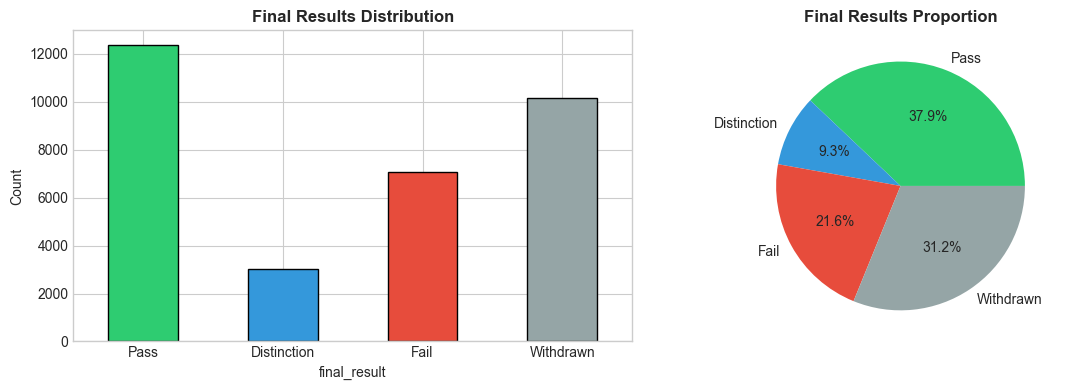

In [10]:
# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

colors = ['#2ecc71', '#3498db', '#e74c3c', '#95a5a6']
order = ['Pass', 'Distinction', 'Fail', 'Withdrawn']

target_counts.reindex(order).plot(kind='bar', ax=axes[0], color=colors, edgecolor='black')
axes[0].set_title('Final Results Distribution', fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

axes[1].pie(target_counts.reindex(order), labels=order, autopct='%1.1f%%', colors=colors)
axes[1].set_title('Final Results Proportion', fontweight='bold')

plt.tight_layout()
plt.show()

## 3.6 Key Variables Exploration

In [11]:
# Demographics
print("Demographic distributions:")
print("-" * 60)
for col in ['gender', 'age_band', 'highest_education']:
    if col in df.columns:
        print(f"\n{col}:")
        print(df[col].value_counts())
print("-" * 60)

Demographic distributions:
------------------------------------------------------------

gender:
gender
M    17875
F    14718
Name: count, dtype: int64

age_band:
age_band
0-35     22944
35-55     9433
55<=       216
Name: count, dtype: int64

highest_education:
highest_education
A Level or Equivalent          14045
Lower Than A Level             13158
HE Qualification                4730
No Formal quals                  347
Post Graduate Qualification      313
Name: count, dtype: int64
------------------------------------------------------------


In [12]:
# Engagement metrics
engagement_cols = ['vle_total_clicks', 'vle_active_days', 'assess_score_mean', 'vle_early_clicks']
engagement_cols = [c for c in engagement_cols if c in df.columns]

if engagement_cols:
    print("Engagement metrics:")
    print("-" * 60)
    print(df[engagement_cols].describe())

Engagement metrics:
------------------------------------------------------------
       vle_total_clicks  vle_active_days  assess_score_mean  vle_early_clicks
count      29228.000000     29228.000000       25820.000000      28081.000000
mean        1355.039654        61.862563          72.768254        220.622556
std         1733.546045        54.027412          16.374997        288.827634
min            1.000000         1.000000           0.000000          1.000000
25%          260.750000        18.000000          64.666667         47.000000
50%          739.500000        47.000000          76.000000        128.000000
75%         1770.000000        92.000000          84.545455        283.000000
max        24139.000000       286.000000         100.000000       5168.000000


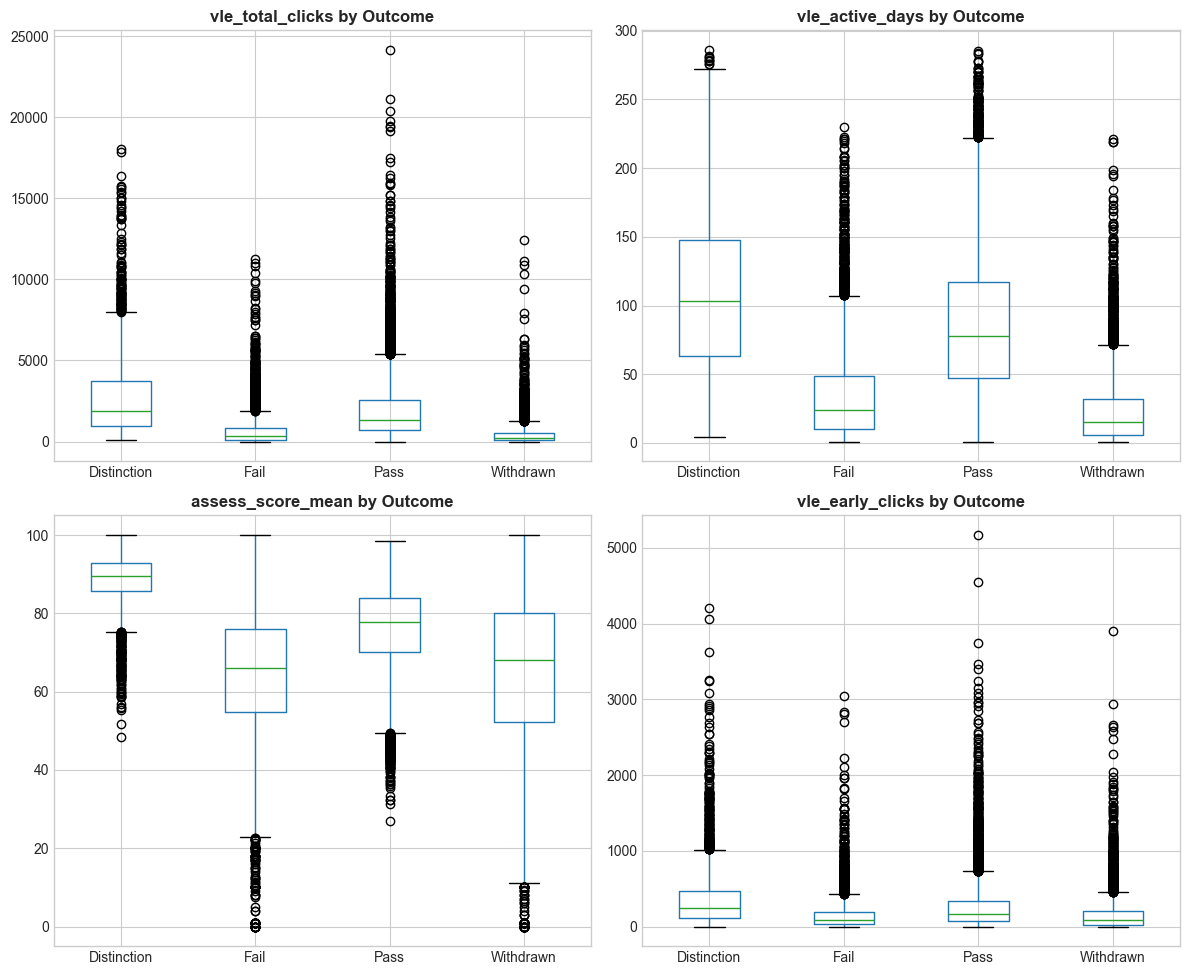

In [13]:
# Box plots by outcome
if engagement_cols:
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    for i, col in enumerate(engagement_cols[:4]):
        df.boxplot(column=col, by='final_result', ax=axes[i])
        axes[i].set_title(f'{col} by Outcome', fontweight='bold')
        axes[i].set_xlabel('')
        plt.suptitle('')

    plt.tight_layout()
    plt.show()

---

# 4️⃣ Phase 3: Data Preparation

## 4.1 Handle Missing Values

In [14]:
print("Step 1: Handle missing values")
print("-" * 60)

df_prep = df.copy()

# Missing indicator for imd_band
if 'imd_band' in df_prep.columns:
    df_prep['imd_band_missing'] = df_prep['imd_band'].isna().astype(int)
    df_prep['imd_band'] = df_prep['imd_band'].fillna('Unknown')
    print("✓ imd_band: Created missing indicator, filled with 'Unknown'")

# Fill VLE columns with 0 (no activity = 0 clicks)
vle_cols = [c for c in df_prep.columns if c.startswith('vle_')]
df_prep[vle_cols] = df_prep[vle_cols].fillna(0)
print(f"✓ VLE columns: Filled {len(vle_cols)} columns with 0")

# Fill assessment columns with 0
assess_cols = [c for c in df_prep.columns if c.startswith('assess_') or 'score' in c.lower()]
df_prep[assess_cols] = df_prep[assess_cols].fillna(0)
print(f"✓ Assessment columns: Filled {len(assess_cols)} columns with 0")

# Impute remaining numerical with median
num_cols = df_prep.select_dtypes(include=[np.number]).columns
cols_na = [c for c in num_cols if df_prep[c].isna().any()]

if cols_na:
    imputer = SimpleImputer(strategy='median')
    df_prep[cols_na] = imputer.fit_transform(df_prep[cols_na])
    print(f"✓ Imputed {len(cols_na)} columns with median")

print(f"\nRemaining missing: {df_prep.isna().sum().sum()}")
print("-" * 60)

Step 1: Handle missing values
------------------------------------------------------------
✓ imd_band: Created missing indicator, filled with 'Unknown'
✓ VLE columns: Filled 34 columns with 0
✓ Assessment columns: Filled 15 columns with 0
✓ Imputed 5 columns with median

Remaining missing: 0
------------------------------------------------------------


## 4.2 Encode Categorical Variables

In [15]:
print("Step 2: Encode categorical variables")
print("-" * 60)

# One-hot encoding
for col in ['gender', 'disability']:
    if col in df_prep.columns:
        dummies = pd.get_dummies(df_prep[col], prefix=col, drop_first=True)
        df_prep = pd.concat([df_prep, dummies], axis=1)
        print(f"✓ One-hot encoded: {col}")

# Ordinal encoding for education
edu_map = {
    'No Formal quals': 0, 'Lower Than A Level': 1,
    'A Level or Equivalent': 2, 'HE Qualification': 3,
    'Post Graduate Qualification': 4
}
if 'highest_education' in df_prep.columns:
    df_prep['education_level'] = df_prep['highest_education'].map(edu_map)
    print("✓ Ordinal encoded: highest_education")

# Ordinal encoding for age
age_map = {'0-35': 0, '35-55': 1, '55<=': 2}
if 'age_band' in df_prep.columns:
    df_prep['age_level'] = df_prep['age_band'].map(age_map)
    print("✓ Ordinal encoded: age_band")

print("-" * 60)

Step 2: Encode categorical variables
------------------------------------------------------------
✓ One-hot encoded: gender
✓ One-hot encoded: disability
✓ Ordinal encoded: highest_education
✓ Ordinal encoded: age_band
------------------------------------------------------------


## 4.3 Create Target Variable

In [16]:
print("Step 3: Create binary target")
print("-" * 60)

# 1 = Success (Pass/Distinction), 0 = Failure (Fail/Withdrawn)
df_prep['target'] = df_prep['final_result'].apply(
    lambda x: 1 if x in ['Pass', 'Distinction'] else 0
)

print("Target distribution:")
print(df_prep['target'].value_counts())
print(f"\nSuccess rate: {df_prep['target'].mean()*100:.1f}%")
print("-" * 60)

Step 3: Create binary target
------------------------------------------------------------
Target distribution:
target
0    17208
1    15385
Name: count, dtype: int64

Success rate: 47.2%
------------------------------------------------------------


## 4.4 Feature Selection (Top K by Correlation)

In [17]:
print("Step 4: Identify all candidate features")
print("-" * 60)

# Columns to exclude from features
exclude = ['id_student', 'student_module_key', 'code_module', 'code_presentation',
           'gender', 'region', 'highest_education', 'imd_band', 'age_band', 'disability',
           'final_result', 'target', 'date_registration', 'date_unregistration']

candidates = [c for c in df_prep.columns 
              if c not in exclude 
              and df_prep[c].dtype in ['int64', 'float64', 'int32', 'float32', 'bool', 'uint8']]

print(f"Total candidate features: {len(candidates)}")
print("-" * 60)

Step 4: Identify all candidate features
------------------------------------------------------------
Total candidate features: 60
------------------------------------------------------------


In [18]:
print("Step 5: Calculate correlation with target")
print("-" * 60)

# Correlation with target
corr = df_prep[candidates + ['target']].corr()['target'].drop('target')
corr_abs = corr.abs().sort_values(ascending=False)

print("Top 20 features by |correlation| with target:")
print("-" * 60)
for i, (feat, c) in enumerate(corr_abs.head(20).items(), 1):
    sign = '+' if corr[feat] > 0 else '-'
    print(f"{i:2}. {feat}: {sign}{c:.4f}")
print("-" * 60)

Step 5: Calculate correlation with target
------------------------------------------------------------
Top 20 features by |correlation| with target:
------------------------------------------------------------
 1. vle_last_access_day: +0.7826
 2. assess_submit_day_max: +0.7793
 3. vle_engagement_span: +0.7770
 4. assess_submit_day_mean: +0.7552
 5. assess_count: +0.7147
 6. assess_total_weight: +0.6486
 7. vle_active_days: +0.6260
 8. assess_score_max: +0.6139
 9. assess_score_mean: +0.6013
10. tma_score_mean: +0.5835
11. vle_unique_resources: +0.5335
12. tma_count: +0.5329
13. assess_score_min: +0.4767
14. vle_total_clicks: +0.4766
15. vle_clicks_homepage: +0.4351
16. cma_score_mean: +0.4026
17. vle_clicks_oucontent: +0.3801
18. cma_count: +0.3758
19. vle_clicks_subpage: +0.3734
20. exam_score_mean: +0.3673
------------------------------------------------------------


In [19]:
# ===========================
# SELECT TOP K FEATURES
# ===========================
K = 15  # Number of features to use

selected_features = corr_abs.head(K).index.tolist()

print(f"\n✓ Selected TOP {K} FEATURES for modelling:")
print("=" * 60)
for i, feat in enumerate(selected_features, 1):
    c = corr[feat]
    print(f"{i:2}. {feat} (r = {c:+.4f})")
print("=" * 60)


✓ Selected TOP 15 FEATURES for modelling:
 1. vle_last_access_day (r = +0.7826)
 2. assess_submit_day_max (r = +0.7793)
 3. vle_engagement_span (r = +0.7770)
 4. assess_submit_day_mean (r = +0.7552)
 5. assess_count (r = +0.7147)
 6. assess_total_weight (r = +0.6486)
 7. vle_active_days (r = +0.6260)
 8. assess_score_max (r = +0.6139)
 9. assess_score_mean (r = +0.6013)
10. tma_score_mean (r = +0.5835)
11. vle_unique_resources (r = +0.5335)
12. tma_count (r = +0.5329)
13. assess_score_min (r = +0.4767)
14. vle_total_clicks (r = +0.4766)
15. vle_clicks_homepage (r = +0.4351)


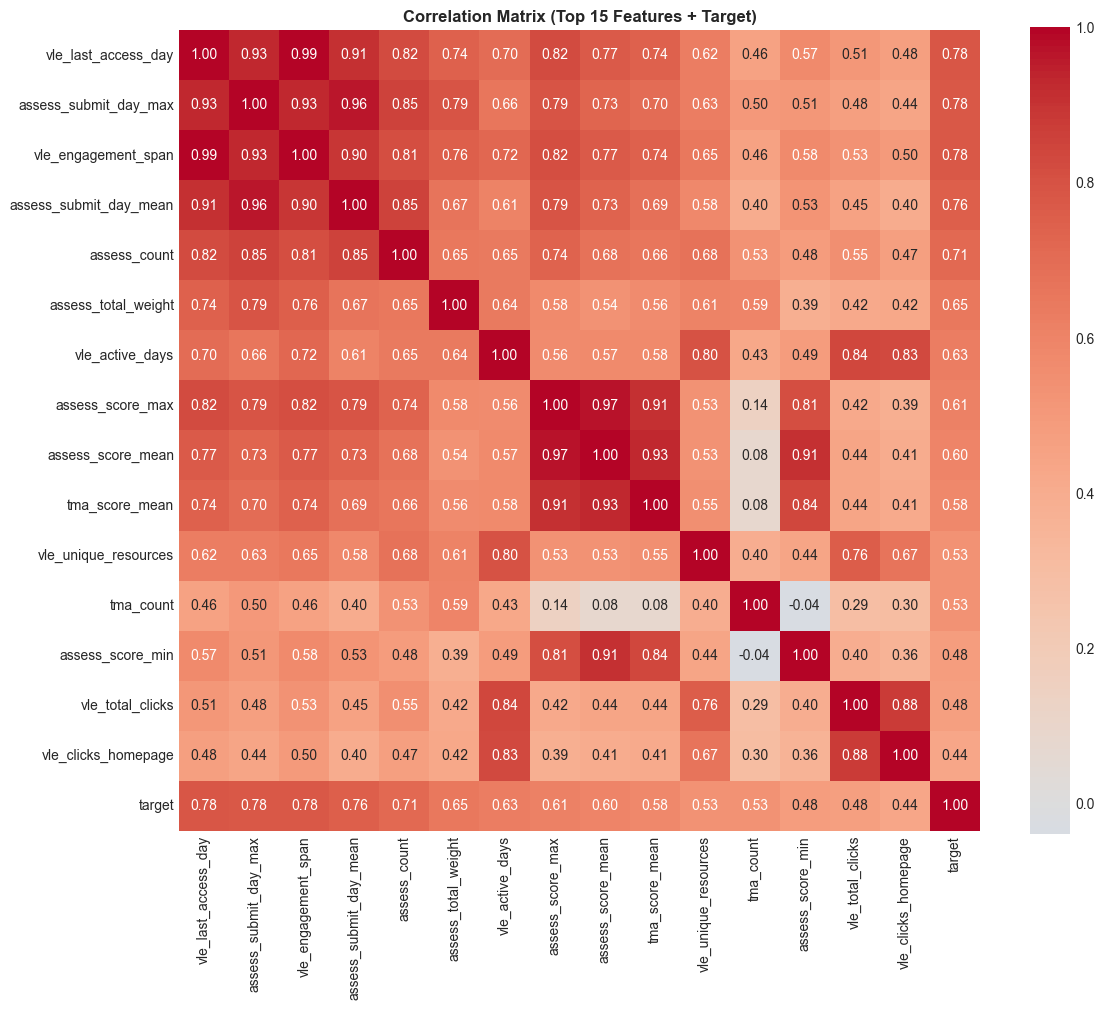

In [20]:
# Correlation heatmap
plt.figure(figsize=(12, 10))
corr_matrix = df_prep[selected_features + ['target']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', square=True)
plt.title(f'Correlation Matrix (Top {K} Features + Target)', fontweight='bold')
plt.tight_layout()
plt.show()

## 4.5 Prepare Final Dataset

In [21]:
print("Step 6: Create feature matrix with selected features")
print("-" * 60)

# Use ONLY the selected K features
X = df_prep[selected_features].copy()
y = df_prep['target'].copy()

# Handle any infinities
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

print(f"Feature matrix X: {X.shape[0]:,} rows x {X.shape[1]} features")
print(f"Target vector y: {y.shape[0]:,} values")
print("-" * 60)

Step 6: Create feature matrix with selected features
------------------------------------------------------------
Feature matrix X: 32,593 rows x 15 features
Target vector y: 32,593 values
------------------------------------------------------------


---

# 5️⃣ Phase 4: Modelling - Task 1 (Classification)

## 5.1 Train-Test Split

In [22]:
print("Step 7: Train-test split (stratified)")
print("-" * 60)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"Number of features: {X_train.shape[1]}")
print("-" * 60)

Step 7: Train-test split (stratified)
------------------------------------------------------------
Training set: 26,074 samples
Test set: 6,519 samples
Number of features: 15
------------------------------------------------------------


## 5.2 Scale Features

In [23]:
print("Step 8: Scale features using StandardScaler")
print("-" * 60)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Features scaled (mean=0, std=1)")
print("-" * 60)

Step 8: Scale features using StandardScaler
------------------------------------------------------------
✓ Features scaled (mean=0, std=1)
------------------------------------------------------------


## 5.3 Train Models

In [24]:
print("Step 9: Train and evaluate models")
print("-" * 60)

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    if 'Logistic' in name:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
    
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'AUC-ROC': roc_auc_score(y_test, y_proba)
    }
    
    print(f"  Accuracy: {results[name]['Accuracy']:.4f}")
    print(f"  AUC-ROC:  {results[name]['AUC-ROC']:.4f}")

print("\n" + "-" * 60)

Step 9: Train and evaluate models
------------------------------------------------------------

Training Logistic Regression...
  Accuracy: 0.9320
  AUC-ROC:  0.9781

Training Random Forest...
  Accuracy: 0.9478
  AUC-ROC:  0.9860

Training Gradient Boosting...
  Accuracy: 0.9475
  AUC-ROC:  0.9865

------------------------------------------------------------


## 5.4 Model Comparison

In [25]:
print("Step 10: Compare models")
print("-" * 60)

results_df = pd.DataFrame(results).T
print(results_df.round(4))

best_model = results_df['AUC-ROC'].idxmax()
print(f"\n🏆 Best model (by AUC-ROC): {best_model}")
print("-" * 60)

Step 10: Compare models
------------------------------------------------------------
                     Accuracy  Precision  Recall      F1  AUC-ROC
Logistic Regression    0.9320     0.8986  0.9649  0.9306   0.9781
Random Forest          0.9478     0.9215  0.9724  0.9462   0.9860
Gradient Boosting      0.9475     0.9219  0.9711  0.9459   0.9865

🏆 Best model (by AUC-ROC): Gradient Boosting
------------------------------------------------------------


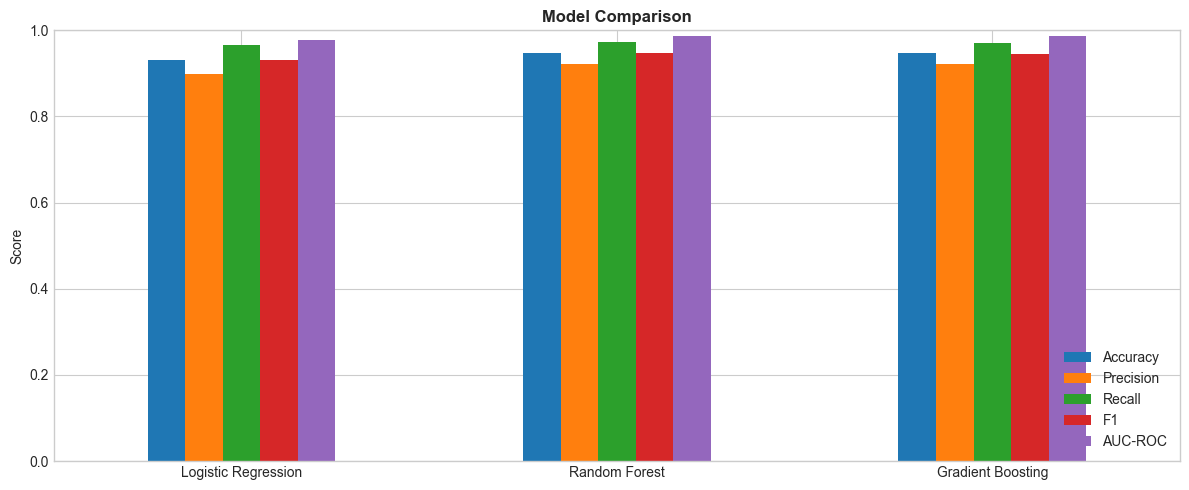

In [26]:
# Visualize
results_df.plot(kind='bar', figsize=(12, 5))
plt.title('Model Comparison', fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

## 5.5 Best Model Analysis

In [27]:
print("Step 11: Detailed Random Forest analysis")
print("-" * 60)

rf = models['Random Forest']
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred_rf, 
                            target_names=['Fail/Withdrawn', 'Pass/Distinction']))

Step 11: Detailed Random Forest analysis
------------------------------------------------------------
Classification Report:
                  precision    recall  f1-score   support

  Fail/Withdrawn       0.97      0.93      0.95      3442
Pass/Distinction       0.92      0.97      0.95      3077

        accuracy                           0.95      6519
       macro avg       0.95      0.95      0.95      6519
    weighted avg       0.95      0.95      0.95      6519



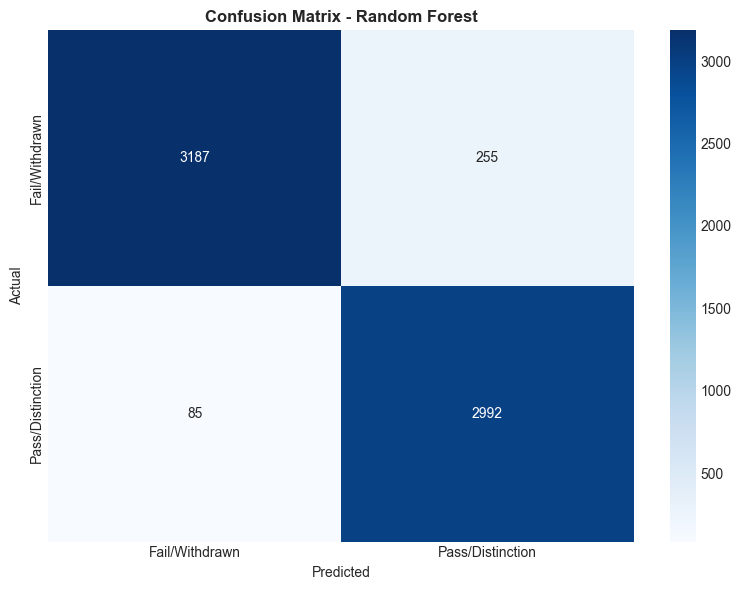

In [28]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fail/Withdrawn', 'Pass/Distinction'],
            yticklabels=['Fail/Withdrawn', 'Pass/Distinction'])
plt.title('Confusion Matrix - Random Forest', fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

## 5.6 Feature Importance

In [29]:
print("Step 12: Feature importance")
print("-" * 60)

importance = pd.DataFrame({
    'Feature': selected_features,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("Feature importance (Random Forest):")
for _, row in importance.iterrows():
    print(f"  {row['Feature']}: {row['Importance']:.4f}")
print("-" * 60)

Step 12: Feature importance
------------------------------------------------------------
Feature importance (Random Forest):
  vle_last_access_day: 0.1746
  assess_submit_day_max: 0.1566
  assess_submit_day_mean: 0.1497
  vle_engagement_span: 0.1097
  assess_total_weight: 0.0991
  assess_count: 0.0494
  vle_active_days: 0.0397
  vle_clicks_homepage: 0.0372
  assess_score_mean: 0.0370
  assess_score_max: 0.0317
  tma_score_mean: 0.0296
  assess_score_min: 0.0282
  vle_total_clicks: 0.0231
  tma_count: 0.0197
  vle_unique_resources: 0.0146
------------------------------------------------------------


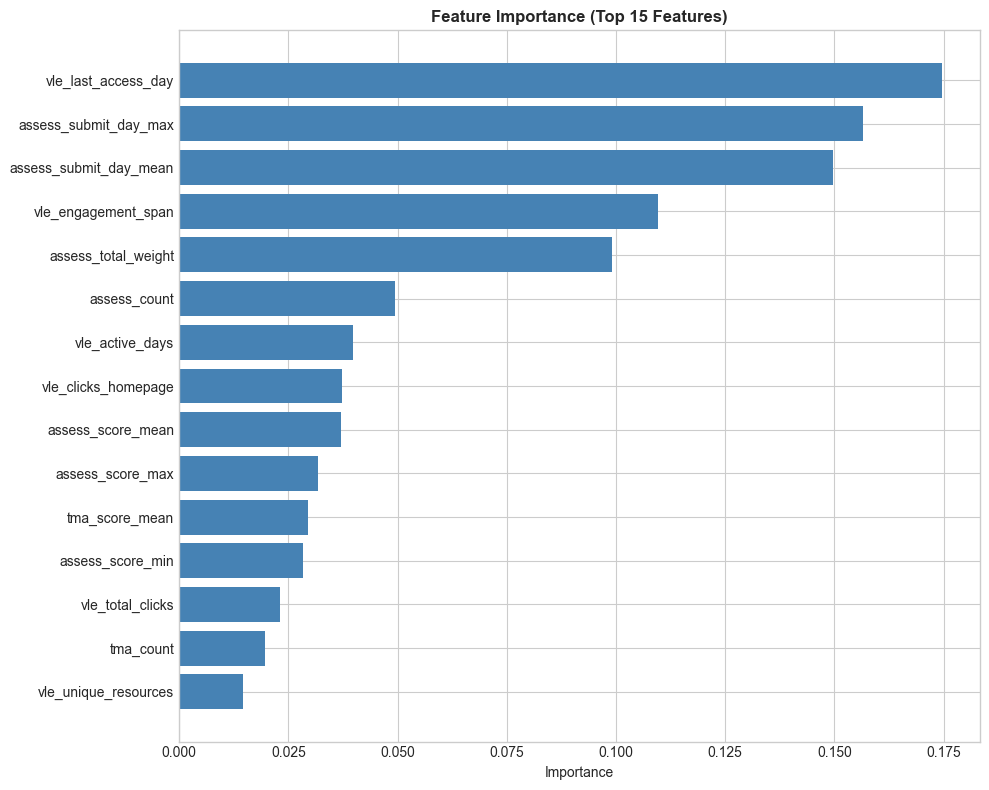

In [30]:
# Visualize
plt.figure(figsize=(10, 8))
plt.barh(range(len(importance)), importance['Importance'], color='steelblue')
plt.yticks(range(len(importance)), importance['Feature'])
plt.xlabel('Importance')
plt.title(f'Feature Importance (Top {K} Features)', fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 5.7 ROC Curves

Step 13: ROC curves
------------------------------------------------------------


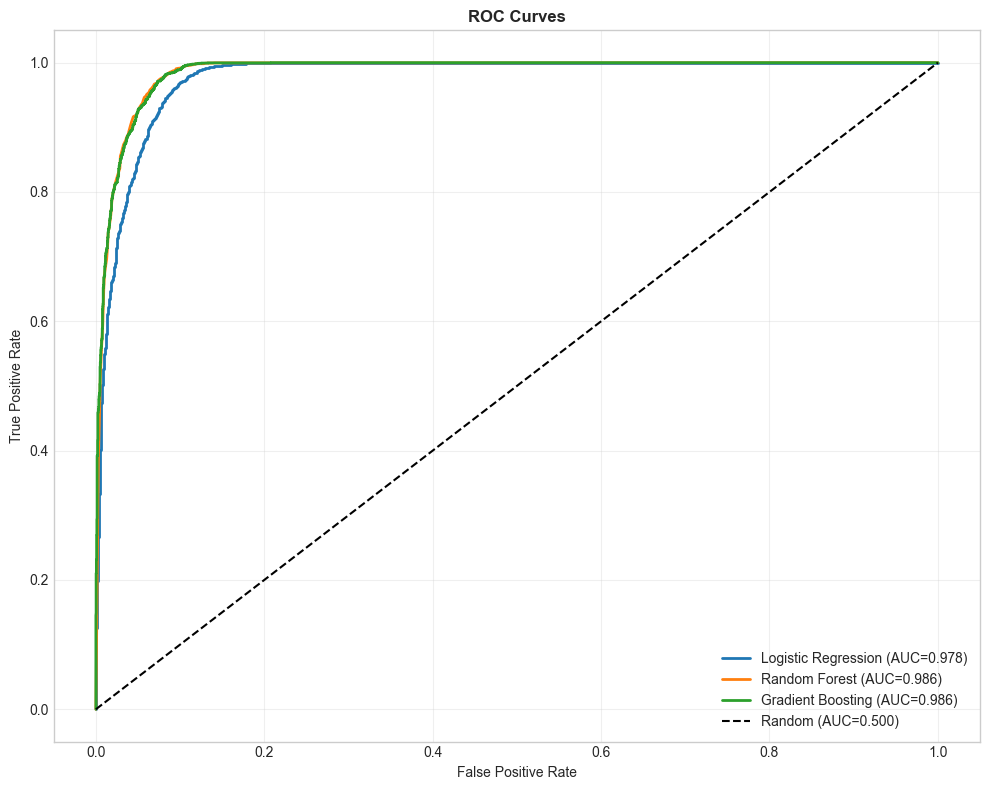

In [31]:
print("Step 13: ROC curves")
print("-" * 60)

plt.figure(figsize=(10, 8))

for name, model in models.items():
    if 'Logistic' in name:
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_proba = model.predict_proba(X_test)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC=0.500)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5.8 Hyperparameter Tuning

In [32]:
print("Step 14: GridSearchCV for Random Forest")
print("-" * 60)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1
)
grid.fit(X_train, y_train)

print(f"\nBest parameters: {grid.best_params_}")
print(f"Best CV AUC-ROC: {grid.best_score_:.4f}")

# Evaluate on test set
best_rf = grid.best_estimator_
y_pred_best = best_rf.predict(X_test)
y_proba_best = best_rf.predict_proba(X_test)[:, 1]

print(f"\nTest AUC-ROC: {roc_auc_score(y_test, y_proba_best):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print("-" * 60)

Step 14: GridSearchCV for Random Forest
------------------------------------------------------------
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Best CV AUC-ROC: 0.9851

Test AUC-ROC: 0.9865
Test Accuracy: 0.9466
------------------------------------------------------------


## 5.9 Cross-Validation

In [33]:
print("Step 15: 5-Fold Cross-Validation")
print("-" * 60)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_rf, X, y, cv=cv, scoring='roc_auc')

print(f"CV AUC-ROC scores: {cv_scores.round(4)}")
print(f"Mean: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print("-" * 60)

Step 15: 5-Fold Cross-Validation
------------------------------------------------------------
CV AUC-ROC scores: [0.9852 0.9856 0.9846 0.9859 0.9857]
Mean: 0.9854 ± 0.0005
------------------------------------------------------------


---

# 6️⃣ Phase 4: Modelling - Task 2 (Clustering)

## 6.1 Select Clustering Features

In [34]:
print("Step 16: Select engagement features for clustering")
print("-" * 60)

# Use engagement-focused subset
cluster_features = [
    'vle_total_clicks', 'vle_active_days', 'vle_unique_resources',
    'vle_early_clicks', 'assess_score_mean', 'assess_count'
]
cluster_features = [f for f in cluster_features if f in df_prep.columns]

print(f"Using {len(cluster_features)} features:")
for f in cluster_features:
    print(f"  - {f}")
print("-" * 60)

Step 16: Select engagement features for clustering
------------------------------------------------------------
Using 6 features:
  - vle_total_clicks
  - vle_active_days
  - vle_unique_resources
  - vle_early_clicks
  - assess_score_mean
  - assess_count
------------------------------------------------------------


In [35]:
# Prepare and scale
X_cluster = df_prep[cluster_features].fillna(0)
scaler_c = StandardScaler()
X_cluster_scaled = scaler_c.fit_transform(X_cluster)

print(f"Clustering data: {X_cluster_scaled.shape}")

Clustering data: (32593, 6)


## 6.2 Find Optimal K

In [36]:
print("Step 17: Evaluate k values")
print("-" * 60)

K_range = range(2, 11)
inertias, silhouettes, db_scores = [], [], []

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_cluster_scaled)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_cluster_scaled, labels))
    db_scores.append(davies_bouldin_score(X_cluster_scaled, labels))
    print(f"k={k}: Silhouette={silhouettes[-1]:.4f}, DB={db_scores[-1]:.4f}")

print("-" * 60)

Step 17: Evaluate k values
------------------------------------------------------------
k=2: Silhouette=0.4078, DB=1.0298
k=3: Silhouette=0.4341, DB=0.8789
k=4: Silhouette=0.4093, DB=0.9992
k=5: Silhouette=0.3765, DB=1.0851
k=6: Silhouette=0.3799, DB=1.1082
k=7: Silhouette=0.3889, DB=1.1558
k=8: Silhouette=0.3892, DB=1.1503
k=9: Silhouette=0.3786, DB=1.1831
k=10: Silhouette=0.3781, DB=1.2155
------------------------------------------------------------


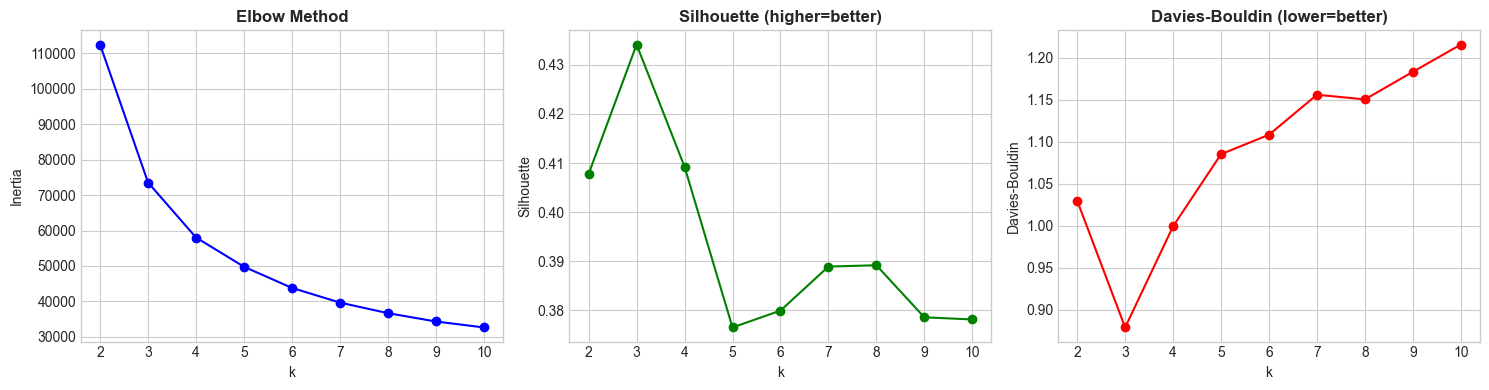

In [37]:
# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(K_range, inertias, 'bo-')
axes[0].set_xlabel('k')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method', fontweight='bold')

axes[1].plot(K_range, silhouettes, 'go-')
axes[1].set_xlabel('k')
axes[1].set_ylabel('Silhouette')
axes[1].set_title('Silhouette (higher=better)', fontweight='bold')

axes[2].plot(K_range, db_scores, 'ro-')
axes[2].set_xlabel('k')
axes[2].set_ylabel('Davies-Bouldin')
axes[2].set_title('Davies-Bouldin (lower=better)', fontweight='bold')

plt.tight_layout()
plt.show()

## 6.3 Fit Final K-Means

In [38]:
print("Step 18: Fit K-Means")
print("-" * 60)

# Choose k based on plots above
OPTIMAL_K = 3

kmeans = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_cluster_scaled)
df_prep['cluster'] = cluster_labels

print(f"K-Means with k={OPTIMAL_K}:")
for c in range(OPTIMAL_K):
    n = (cluster_labels == c).sum()
    pct = n / len(cluster_labels) * 100
    print(f"  Cluster {c}: {n:,} ({pct:.1f}%)")

print(f"\nSilhouette Score: {silhouette_score(X_cluster_scaled, cluster_labels):.4f}")
print("-" * 60)

Step 18: Fit K-Means
------------------------------------------------------------
K-Means with k=3:
  Cluster 0: 8,485 (26.0%)
  Cluster 1: 18,293 (56.1%)
  Cluster 2: 5,815 (17.8%)

Silhouette Score: 0.4341
------------------------------------------------------------


## 6.4 Cluster Profiling

In [39]:
print("Step 19: Profile clusters")
print("-" * 60)

profiles = df_prep.groupby('cluster')[cluster_features].mean()
print("Cluster centroids (mean values):")
print(profiles.round(2).T)
print("-" * 60)

Step 19: Profile clusters
------------------------------------------------------------
Cluster centroids (mean values):
cluster                   0       1        2
vle_total_clicks      76.28  865.49  3976.86
vle_active_days        5.04   51.05   142.99
vle_unique_resources  10.10   55.75   147.04
vle_early_clicks      40.48  141.35   561.66
assess_score_mean      7.56   73.72    80.17
assess_count           0.32    6.21     9.86
------------------------------------------------------------


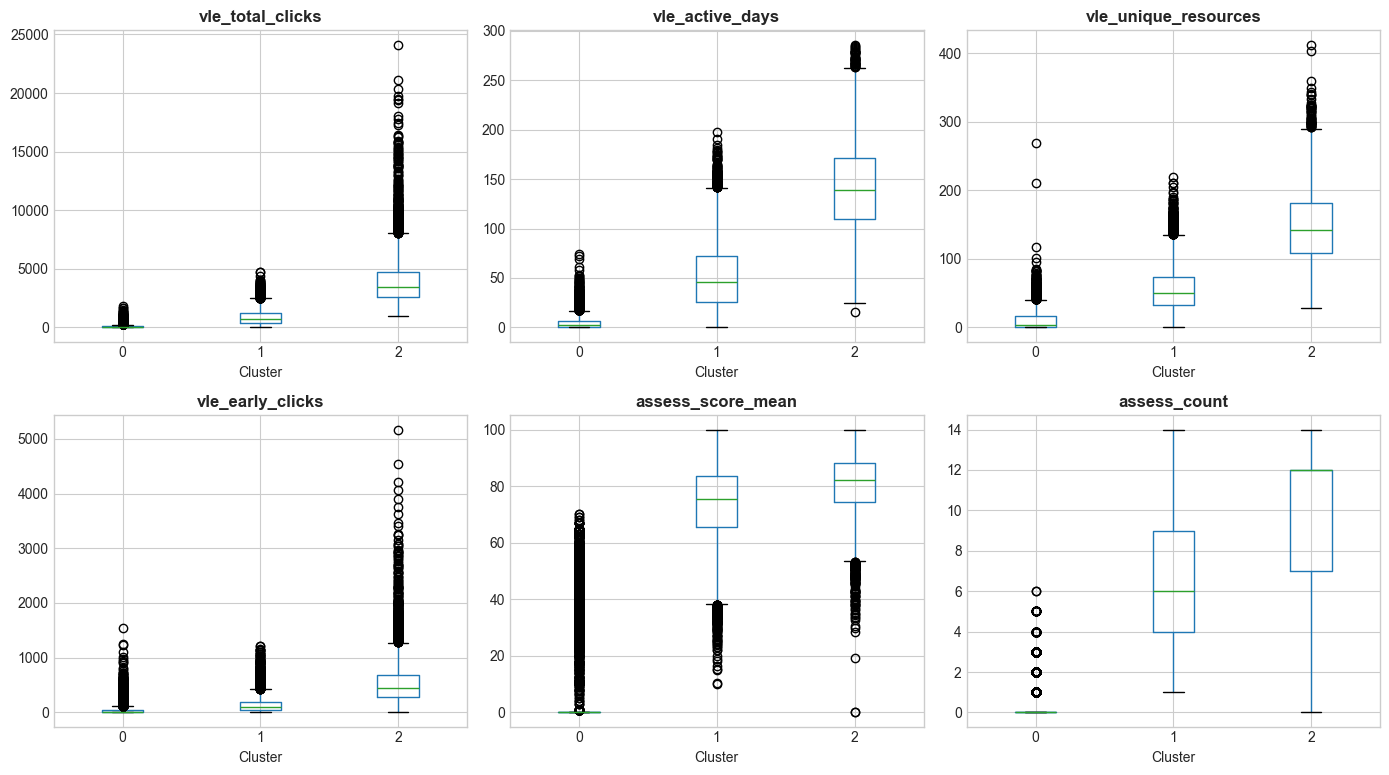

In [40]:
# Visualize
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for i, feat in enumerate(cluster_features[:6]):
    df_prep.boxplot(column=feat, by='cluster', ax=axes[i])
    axes[i].set_title(feat, fontweight='bold')
    axes[i].set_xlabel('Cluster')
    plt.suptitle('')

plt.tight_layout()
plt.show()

## 6.5 Clusters vs Outcomes

In [41]:
print("Step 20: Cluster vs outcome analysis")
print("-" * 60)

crosstab = pd.crosstab(df_prep['cluster'], df_prep['final_result'], normalize='index') * 100
print("Outcome % by cluster:")
print(crosstab.round(1))

success_rate = df_prep.groupby('cluster')['target'].mean() * 100
print("\nSuccess rate by cluster:")
for c, rate in success_rate.items():
    risk = 'HIGH RISK' if rate < 50 else 'MEDIUM' if rate < 70 else 'LOW RISK'
    print(f"  Cluster {c}: {rate:.1f}% - {risk}")
print("-" * 60)

Step 20: Cluster vs outcome analysis
------------------------------------------------------------
Outcome % by cluster:
final_result  Distinction  Fail  Pass  Withdrawn
cluster                                         
0                     0.0  24.2   0.1       75.8
1                     9.1  25.0  46.6       19.4
2                    23.5   7.4  66.0        3.2

Success rate by cluster:
  Cluster 0: 0.1% - HIGH RISK
  Cluster 1: 55.6% - MEDIUM
  Cluster 2: 89.4% - LOW RISK
------------------------------------------------------------


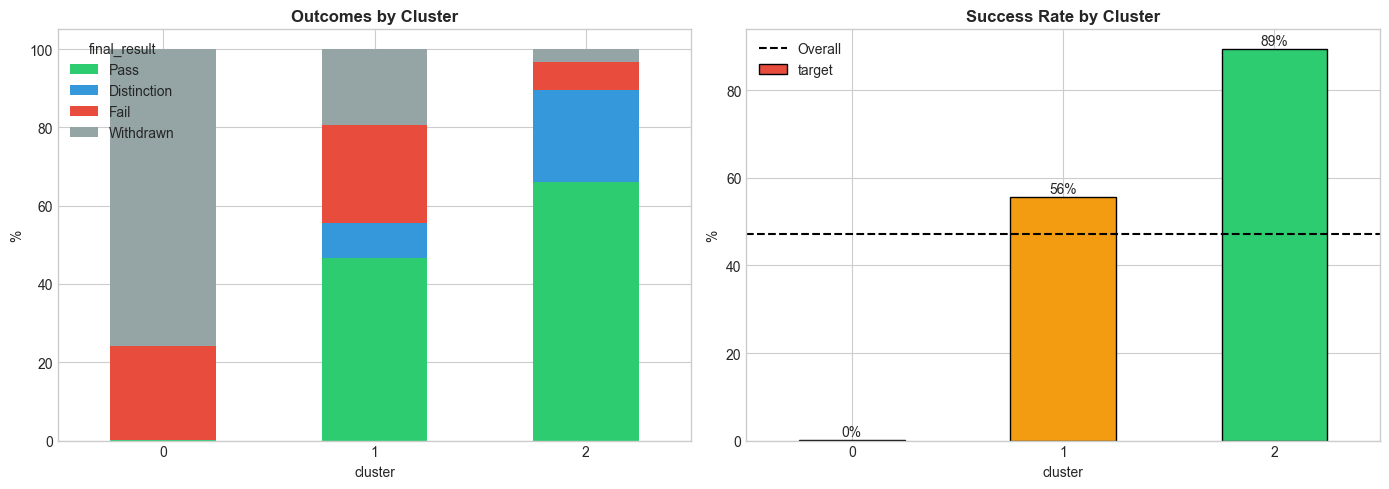

In [42]:
# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

order = ['Pass', 'Distinction', 'Fail', 'Withdrawn']
cols = [c for c in order if c in crosstab.columns]
crosstab[cols].plot(kind='bar', stacked=True, ax=axes[0],
                    color=['#2ecc71', '#3498db', '#e74c3c', '#95a5a6'])
axes[0].set_title('Outcomes by Cluster', fontweight='bold')
axes[0].set_ylabel('%')
axes[0].tick_params(axis='x', rotation=0)

colors = ['#e74c3c' if r < 50 else '#f39c12' if r < 70 else '#2ecc71' for r in success_rate]
success_rate.plot(kind='bar', ax=axes[1], color=colors, edgecolor='black')
axes[1].set_title('Success Rate by Cluster', fontweight='bold')
axes[1].set_ylabel('%')
axes[1].tick_params(axis='x', rotation=0)
axes[1].axhline(df_prep['target'].mean()*100, color='black', linestyle='--', label='Overall')
axes[1].legend()

for i, v in enumerate(success_rate):
    axes[1].text(i, v+1, f'{v:.0f}%', ha='center')

plt.tight_layout()
plt.show()

## 6.6 PCA Visualization

Step 21: PCA visualization
------------------------------------------------------------
Variance: PC1=68.3%, PC2=15.3%


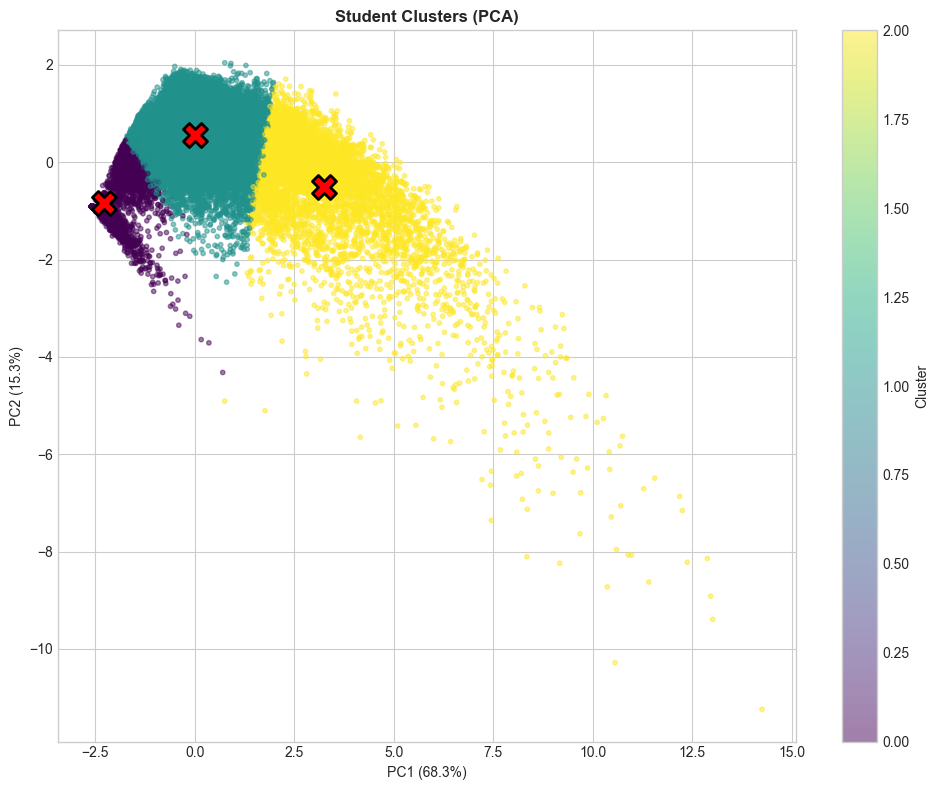

In [43]:
print("Step 21: PCA visualization")
print("-" * 60)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster_scaled)

print(f"Variance: PC1={pca.explained_variance_ratio_[0]:.1%}, PC2={pca.explained_variance_ratio_[1]:.1%}")

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5, s=10)
plt.colorbar(scatter, label='Cluster')

centers = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='X', s=300, edgecolors='black', linewidths=2)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
plt.title('Student Clusters (PCA)', fontweight='bold')
plt.tight_layout()
plt.show()

---

# 7️⃣ Phase 5: Evaluation Summary

In [46]:
print("=" * 60)
print("              EVALUATION SUMMARY")
print("=" * 60)

print("\n--- TASK 1: CLASSIFICATION ---")
print(f"Model: Random Forest (tuned)")
print(f"Features used: {K}")
print(f"Test AUC-ROC: {roc_auc_score(y_test, y_proba_best):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print(f"CV AUC-ROC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

print("\nTop 5 predictors:")
for _, row in importance.head(5).iterrows():
    print(f"  - {row['Feature']}: {row['Importance']:.4f}")

print("\n--- TASK 2: CLUSTERING ---")
print(f"Algorithm: K-Means (k={OPTIMAL_K})")
print(f"Features used: {len(cluster_features)}")
print(f"Silhouette: {silhouette_score(X_cluster_scaled, cluster_labels):.4f}")

print("\nCluster risk levels:")
for c, rate in success_rate.items():
    risk = 'HIGH RISK' if rate < 50 else 'MEDIUM' if rate < 70 else 'LOW RISK'
    print(f"  Cluster {c}: {rate:.1f}% success → {risk}")

print("\n--- SUCCESS CRITERIA CHECK ---")
auc_val = roc_auc_score(y_test, y_proba_best)
sil_val = silhouette_score(X_cluster_scaled, cluster_labels)
print(f"{'✓' if auc_val > 0.75 else '✗'} AUC-ROC > 0.75: {auc_val:.4f}")
print(f"{'✓' if sil_val > 0.2 else '✗'} Silhouette > 0.2: {sil_val:.4f}")
print("=" * 60)

              EVALUATION SUMMARY

--- TASK 1: CLASSIFICATION ---
Model: Random Forest (tuned)
Features used: 15
Test AUC-ROC: 0.9865
Test Accuracy: 0.9466
CV AUC-ROC: 0.9854 ± 0.0005

Top 5 predictors:
  - vle_last_access_day: 0.1746
  - assess_submit_day_max: 0.1566
  - assess_submit_day_mean: 0.1497
  - vle_engagement_span: 0.1097
  - assess_total_weight: 0.0991

--- TASK 2: CLUSTERING ---
Algorithm: K-Means (k=3)
Features used: 6
Silhouette: 0.4341

Cluster risk levels:
  Cluster 0: 0.1% success → HIGH RISK
  Cluster 1: 55.6% success → MEDIUM
  Cluster 2: 89.4% success → LOW RISK

--- SUCCESS CRITERIA CHECK ---
✓ AUC-ROC > 0.75: 0.9865
✓ Silhouette > 0.2: 0.4341


---

# 8️⃣ Phase 6: Deployment Recommendations

In [45]:
print("=" * 60)
print("         DEPLOYMENT RECOMMENDATIONS")
print("=" * 60)

print("""
📋 EARLY WARNING SYSTEM
───────────────────────
1. Deploy Random Forest model to flag at-risk students
2. Run predictions weekly during first 4 weeks
3. Focus on key predictors: VLE engagement, assessment scores

👥 CLUSTER-BASED INTERVENTIONS
──────────────────────────────""")

for c in range(OPTIMAL_K):
    rate = success_rate[c]
    if rate < 50:
        print(f"  Cluster {c} ({rate:.0f}%): Intensive support, personal tutor")
    elif rate < 70:
        print(f"  Cluster {c} ({rate:.0f}%): Study skills workshops")
    else:
        print(f"  Cluster {c} ({rate:.0f}%): Light monitoring")

print("""
⚠️ LIMITATIONS
──────────────
• Based on historical data
• Cannot capture external factors
• Needs periodic retraining
""")
print("=" * 60)

         DEPLOYMENT RECOMMENDATIONS

📋 EARLY WARNING SYSTEM
───────────────────────
1. Deploy Random Forest model to flag at-risk students
2. Run predictions weekly during first 4 weeks
3. Focus on key predictors: VLE engagement, assessment scores

👥 CLUSTER-BASED INTERVENTIONS
──────────────────────────────
  Cluster 0 (0%): Intensive support, personal tutor
  Cluster 1 (56%): Study skills workshops
  Cluster 2 (89%): Light monitoring

⚠️ LIMITATIONS
──────────────
• Based on historical data
• Cannot capture external factors
• Needs periodic retraining



---

# 📝 Summary

| Phase | Status |
|-------|--------|
| 1. Business Understanding | ✓ |
| 2. Data Understanding | ✓ |
| 3. Data Preparation | ✓ |
| 4. Modelling | ✓ |
| 5. Evaluation | ✓ |
| 6. Deployment | ✓ |

**Key decisions:**
- Selected **top 15 features** by correlation (not 89!)
- Used engagement-focused features for clustering
- Identified high-risk clusters for intervention